# Use different metrics to benchmark signature connectivity metrics

The gold standard is the drug MoA from Corsello et al.: https://www.nature.com/nm/journal/v23/n4/full/nm.4306.html

In [1]:
import os, sys, json
from itertools import combinations
import h5py
from pymongo import MongoClient
import numpy as np
import pandas as pd
from scipy import stats
from scipy.spatial import distance
np.random.seed(10)

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 ## Output Type 3 (Type3) or Type 42 (TrueType)
rcParams['font.sans-serif'] = 'Arial'

import seaborn as sns
sns.set_context('talk', font_scale=1.5)


/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
from joblib import delayed, Parallel

# Implement connectivity metrics 

Connectivity Metrics between a pair of signatures:

`sig1` and `sig2` are 1-D `np.array` with same orders of genes


In [4]:
def _gesa_enrichment_score(ranks_s):
    '''Calculate enrichment score from a rank ordered boolean array.
    ranks_s: np.array([0., 1., 0., 0.])
        - 1.: hits
        - 0.: misses
    '''
    n_hits = ranks_s.sum()
    n_misses = ranks_s.shape[0] - n_hits
    
    p_hit = np.cumsum(ranks_s) / n_hits
    p_miss = np.cumsum(1 - ranks_s) / n_misses
    p_diff = np.absolute(p_hit - p_miss)
    idx = np.argmax(p_diff)
    es = p_hit[idx] - p_miss[idx]
    return es
    
def gsea_score(sig1, sig2, n_sig=100):
    '''GSEA-based Kolmogorov-Smirnov statsitics.
    n_sig: number of top ranked genes to be treated as significant
    '''
    # number of genes
    n = len(sig1)
    # rank genes in sig1 (0: most down gene, 977: most up genes)
    ranks1 = stats.rankdata(sig1) - 1 
    # identify top up/down genes in sig1
    sig1_down = ranks1 < n_sig
    sig1_up = ranks1 > (n-1-n_sig)
    # argsort sig2
    sig2_srt_idx = sig2.argsort()
    # Compute ES: sig1 as query, sig2 as ref rank
    es_up1 = _gesa_enrichment_score( sig1_up[sig2_srt_idx].astype(float) )
    es_down1 = _gesa_enrichment_score( sig1_down[sig2_srt_idx].astype(float) )
    
    # rank genes in sig2
    ranks2 = stats.rankdata(sig2) - 1
    # identify top up/down genes in sig2
    sig2_down = ranks2 < n_sig
    sig2_up = ranks2 > (n-1-n_sig)
    # argsort sig1
    sig1_srt_idx = sig1.argsort()
    # Compute ES: sig2 as query, sig1 as ref rank
    es_up2 = _gesa_enrichment_score( sig2_up[sig1_srt_idx].astype(float) )
    es_down2 = _gesa_enrichment_score( sig2_down[sig1_srt_idx].astype(float) )
    
#     print es_up1, es_down1
#     print es_up2, es_down2
    
    # es_up is using up gene set to find hits in a list ascending ordered, 
    # therefore, the desirable sign should be negative
    score = (es_down1 - es_up1 + es_down2 - es_up2) / 4. 
    return score

def cosine_sim(sig1, sig2):
    '''Cosine similarity'''
    return 1 - distance.cosine(sig1, sig2)

def correlation(sig1, sig2):
    '''Pearson correlation'''
    return 1 - distance.correlation(sig1, sig2)

def pscore(mat, func, n_jobs=1, **kwargs):
    '''mat is a signature by gene matrix, apply func to all pairwise signatures.
    Similar to pdist
    '''
    n = mat.shape[0]
    n_scores = n * (n-1) / 2
    scores = np.zeros(n_scores)
    c = 0
    if n_jobs == 1:
        for i, j in combinations(range(n), 2):
            scores[c] = func(mat[i], mat[j])
            c += 1
    else:
        scores = Parallel(n_jobs=n_jobs, backend='multiprocessing', verbose=10)(
            delayed(func)(mat[i], mat[j], **kwargs) for i, j in combinations(range(n), 2))
        scores = np.array(scores)
    return scores

## Check the metrics with random data

In [5]:
sig1 = np.random.randn(978)
sig2 = np.random.randn(978)
sig3 = sig1 + 1.

In [6]:
gsea_score(sig1, sig2, n_sig=50)

0.12504310344827588

In [6]:
print gsea_score(sig1, sig3, n_sig=50)
print cosine_sim(sig1, sig3)
print cosine_sim(sig1, sig1 * 2)
print correlation(sig1, sig3)

1.0
0.677393930887
1.0
1.0


In [7]:
n_sigs = [10, 20, 50, 100]

all_scores = np.zeros((1000, 6))
for i in range(1000):
    sig_n = np.random.randn(978)
    
    es_10 = gsea_score(sig1, sig_n, n_sig=10)
    es_20 = gsea_score(sig1, sig_n, n_sig=20)
    es_50 = gsea_score(sig1, sig_n, n_sig=50)
    es_100 = gsea_score(sig1, sig_n, n_sig=100)
    
    cos = cosine_sim(sig1, sig_n)
    corr = correlation(sig1, sig_n)
    
    all_scores[i] = [es_10, es_20, es_50, es_100, cos, corr]
    
    

In [8]:
all_scores_df = pd.DataFrame(all_scores, 
                             columns=['ES_10', 'ES_20', 'ES_50', 'ES_100', 'cosine', 'correlation'])


/usr/local/lib/python2.7/site-packages/seaborn/categorical.py:1791: UserWarning: The violinplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


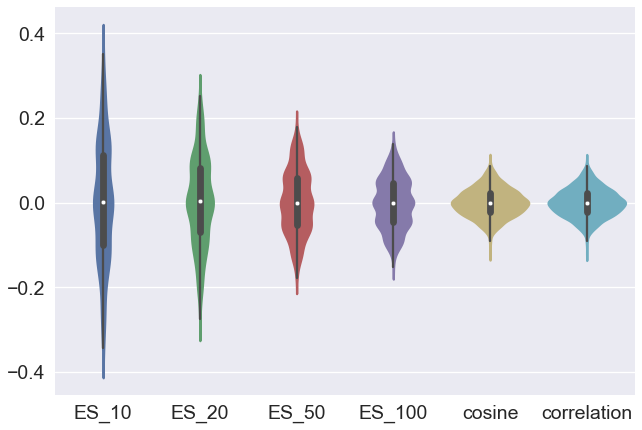

In [9]:
sns.violinplot(all_scores_df)

In [10]:
del all_scores_df

# Read gold standard of drug MoAs

In [5]:
drug_moa_df = pd.read_csv('../../Repurposing_Hub_export.txt', sep='\t')
print drug_moa_df.shape
drug_moa_df.head()

(5628, 5)


,Name,MOA,Target,Id,Phase
0,A-317491,purinergic receptor antagonist,P2RX3,"BRD-K38019854-323-01-4, BRD-K38019854-001-01-6",Preclinical
1,A-33903,NaN,NaN,BRD-A40302156-001-01-9,Phase 2
2,A-366,histone lysine methyltransferase inhibitor,"EHMT1, EHMT2","BRD-K06182768-001-02-3, BRD-K06182768-001-01-5...",Preclinical
3,A-674563,AKT inhibitor,"AKT1, PKIA, PRKACA",BRD-K78177893-001-02-4,Preclinical
4,A-7,calmodulin antagonist,NaN,BRD-K03301001-003-02-5,Preclinical


In [6]:
drug_moa_df['pert_ids'] = drug_moa_df['Id']\
    .map(lambda x: ','.join(set(['-'.join(item.split('-')[0:2]) for item in x.split(', ')])))

drug_moa_df['pert_id_count'] = drug_moa_df['pert_ids']\
    .map(lambda x: len(x.split(',')))

drug_moa_df['pert_id_count'].value_counts()

1    5179
2     359
3      75
4      11
5       4
Name: pert_id_count, dtype: int64

In [7]:
drug_moa_df.query('pert_id_count > 1').head()

,Name,MOA,Target,Id,Phase,pert_ids,pert_id_count
7,abacavir,nucleoside reverse transcriptase inhibitor,NaN,"BRD-A95032015-065-01-2, BRD-K17443395-065-01-4",Launched,"BRD-A95032015,BRD-K17443395",2
13,abiraterone-acetate,androgen biosynthesis inhibitor,CYP17A1,"BRD-K24048528-001-01-7, BRD-K16133773-001-01-9",Launched,"BRD-K24048528,BRD-K16133773",2
26,acadesine,AMPK activator,NaN,"BRD-K53448858-001-07-0, BRD-K04797704-001-01-9",Phase 3,"BRD-K53448858,BRD-K04797704",2
30,acarbose,glucosidase inhibitor,"AMY2A, GAA, MGAM, SI","BRD-A16444946-001-09-7, BRD-K01621533-001-01-1...",Launched,"BRD-K01621533,BRD-K44276885,BRD-A16444946",3
34,aceclidine,acetylcholine receptor agonist,"CHRM1, CHRM2, CHRM3, CHRM4, CHRM5","BRD-A32673558-003-03-9, BRD-A32673558-001-02-5...",Launched,"BRD-K68075732,BRD-A80567352,BRD-A32673558",3


In [8]:
for col in drug_moa_df.columns:
    print col, drug_moa_df[col].nunique()

Name 5628
MOA 1262
Target 2149
Id 5628
Phase 8
pert_ids 5620
pert_id_count 5


In [9]:
drug_moa_df.count()

Name             5628
MOA              5086
Target           4020
Id               5628
Phase            5627
pert_ids         5628
pert_id_count    5628
dtype: int64

In [10]:
drug_moa_df.set_index('Name', inplace=True)

In [11]:
# A dict from pert_id to name
d_pert_name = {}
for name, row in drug_moa_df.iterrows():
    for pert_id in row['pert_ids'].split(','):
        d_pert_name[pert_id] = name
print len(d_pert_name)

6172


# Load signature data and metadata from MongoDB

1. **chdirLm**: CD signatures created by Qiaonan
2. **CD_nocenter_LM**: CD signatures of treatment samples vs other treatment samples in the batch as controls
3. **CD_center_LM**: Same with 2., but perform CD after mean centering
4. **avg_center_LM**: Mean center treatment samples in the batch, then use the mean differences as signature

In [12]:
def retrieve_signature_meta_df(coll, query):
    cur = coll.find(query, 
                    {'sig_id':True,
                     'pert_id':True,
                     '_id':False
                    })
    meta_df = pd.DataFrame([doc for doc in cur]).set_index('sig_id')
    print meta_df.shape
    
    meta_df['batch'] = meta_df.index.map(lambda x: x.split(':')[0])
    meta_df['batch_prefix'] = meta_df['batch'].map(lambda x:x.split('_')[0])
    meta_df['cell_id'] = meta_df['batch'].map(lambda x:x.split('_')[1])
    meta_df['time'] = meta_df['batch'].map(lambda x:x.split('_')[2])
    return meta_df

In [13]:
# CD signatures produced by Qiaonan 
client = MongoClient('mongodb://146.203.54.131:27017/')
coll = client['L1000CDS2']['cpcd-gse70138']
# coll = client['L1000CDS2']['cpcd-gse70138-without-insignificant']

meta_df = retrieve_signature_meta_df(coll, {'pert_type': 'trt_cp'})
print meta_df.shape
meta_df.head()

(117126, 1)
(117126, 5)


,pert_id,batch,batch_prefix,cell_id,time
sig_id,,,,,
CPC001_HA1E_24H:BRD-A82329351:10.0,BRD-A82329351,CPC001_HA1E_24H,CPC001,HA1E,24H
CPC001_HA1E_24H:BRD-K02607075:10.0,BRD-K02607075,CPC001_HA1E_24H,CPC001,HA1E,24H
CPC001_HA1E_24H:BRD-A49906757:10.0,BRD-A49906757,CPC001_HA1E_24H,CPC001,HA1E,24H
CPC001_HA1E_24H:BRD-K85242180:10.0,BRD-K85242180,CPC001_HA1E_24H,CPC001,HA1E,24H
CPC001_HA1E_24H:BRD-K78844995:10.0,BRD-K78844995,CPC001_HA1E_24H,CPC001,HA1E,24H


In [86]:
# coll = client['L1000CDS2']['cpcd-gse70138']
# coll.distinct('pert_type')

[u'trt_poscon', u'trt_cp']

In [14]:
coll_fwd = client['L1000FWD']['sigs']

In [15]:
meta_df_fwd = retrieve_signature_meta_df(coll_fwd, {})
print meta_df_fwd.shape
meta_df_fwd.head()

(128241, 1)
(128241, 5)


,pert_id,batch,batch_prefix,cell_id,time
sig_id,,,,,
CPC006_SNGM_6H:BRD-A20131130-001-01-7:10,BRD-A20131130,CPC006_SNGM_6H,CPC006,SNGM,6H
CPC006_SNGM_6H:BRD-K64890080-001-03-9:10,BRD-K64890080,CPC006_SNGM_6H,CPC006,SNGM,6H
CPC006_SNGM_6H:BRD-A97437073-001-03-1:80,BRD-A97437073,CPC006_SNGM_6H,CPC006,SNGM,6H
CPC006_SNGM_6H:BRD-K83354763-001-01-1:6,BRD-K83354763,CPC006_SNGM_6H,CPC006,SNGM,6H
CPC006_SNGM_6H:BRD-K32405725-001-01-0:88.8,BRD-K32405725,CPC006_SNGM_6H,CPC006,SNGM,6H


In [16]:
print meta_df['batch'].nunique(), meta_df_fwd['batch'].nunique()

371 650


In [17]:
print meta_df['batch_prefix'].nunique(), meta_df_fwd['batch_prefix'].nunique()
shared_batch_prefix = set(meta_df['batch_prefix'].unique()) & set(meta_df_fwd['batch_prefix'].unique())
print len(shared_batch_prefix)


28 123
23


In [18]:
print meta_df['pert_id'].nunique(), meta_df_fwd['pert_id'].nunique()
shared_pert_ids = set(meta_df['pert_id'].unique()) & set(meta_df_fwd['pert_id'].unique())
print len(shared_pert_ids)

5907 5242
5236


In [19]:
# Subset the two meta_df to keep only shared pert_id and batch_prefix
meta_df = meta_df.loc[meta_df['batch_prefix'].isin(shared_batch_prefix) & meta_df['pert_id'].isin(shared_pert_ids)]
print meta_df.shape

meta_df_fwd = meta_df_fwd.loc[meta_df_fwd['batch_prefix'].isin(shared_batch_prefix) & meta_df_fwd['pert_id'].isin(shared_pert_ids)]
print meta_df_fwd.shape

(105514, 5)
(104790, 5)


In [20]:
print meta_df['pert_id'].nunique(), meta_df_fwd['pert_id'].nunique()
print len(set(meta_df['pert_id'].unique()) & set(meta_df_fwd['pert_id'].unique()))

5188 5188
5188


## Signature connectivity scores of same drug on 

1. **Same batch**: same (batch_prefix:cell_id)
2. **Different batch**: same cell_id, different batch_prefix

In [44]:
def retrieve_sig_mat(sig_ids, coll, key):
    '''Retrieve signatures matrix from MongoDB'''
    # Retrieve signature matrix
    sig_mat = np.zeros((len(sig_ids), 978))
    for i, sig_id in enumerate(sig_ids): 
        doc = coll.find_one({'sig_id': sig_id}, {'_id':False, key:True})
        sig_mat[i] = doc[key]
    return sig_mat
    
def compute_connectivity_scores_same_drug_same_batch(meta_df, coll, key):
    '''key is field in the coll that store the signature array'''
    res_same_batch = {
        'cosine': np.array([]),
        'corr': np.array([]),
        'ES50': np.array([]),
    }
    grouped = meta_df.groupby(['batch_prefix', 'cell_id', 'pert_id'])

    c = 0
    for group, sub_df in grouped:
        if sub_df.shape[0] > 1:
            sig_ids = sub_df.index.tolist()
            sig_mat = retrieve_sig_mat(sig_ids, coll, key)

            scores_cosine = pscore(sig_mat, cosine_sim)
            scores_corr = pscore(sig_mat, correlation)
            scores_es50 = pscore(sig_mat, lambda x, y: gsea_score(x, y, 50))

            res_same_batch['cosine'] = np.hstack((res_same_batch['cosine'], scores_cosine))
            res_same_batch['corr'] = np.hstack((res_same_batch['corr'], scores_corr))
            res_same_batch['ES50'] = np.hstack((res_same_batch['ES50'], scores_es50))
        c += 1
        if c % 500 == 0:
            print c, len(grouped)    
    
    return res_same_batch

def compute_connectivity_scores_same_drug_diff_batch(meta_df, coll, key):
    res_diff_batch = {
        'cosine': np.array([]),
        'corr': np.array([]),
        'ES50': np.array([]),
    }

    grouped = meta_df.groupby(['cell_id', 'pert_id'])

    c = 0
    for group, sub_df in grouped:
        if sub_df.shape[0] > 1 and sub_df['batch_prefix'].nunique() > 1:
            sig_ids = sub_df.index.tolist()
            # Retrieve signature matrix
            sig_mat = retrieve_sig_mat(sig_ids, coll, key)

            # Compute scores
            scores_cosine = []
            scores_corr = []
            scores_es50 = []
            for i, j in combinations(range(len(sig_ids)), 2):
                if sub_df.iloc[i]['batch_prefix'] != sub_df.iloc[j]['batch_prefix']:
                    # Not on the same batch
                    scores_cosine.append(cosine_sim(sig_mat[i], sig_mat[j]))
                    scores_corr.append(correlation(sig_mat[i], sig_mat[j]))
                    scores_es50.append(gsea_score(sig_mat[i], sig_mat[j], 50))

            res_diff_batch['cosine'] = np.hstack((res_diff_batch['cosine'], np.array(scores_cosine)))
            res_diff_batch['corr'] = np.hstack((res_diff_batch['corr'], np.array(scores_corr)))
            res_diff_batch['ES50'] = np.hstack((res_diff_batch['ES50'], np.array(scores_es50)))

        c += 1
        if c % 500 == 0:
            print c, len(grouped)    
    return res_diff_batch

In [38]:
drugs_same_batch = set()
for group, sub_df in meta_df_fwd.groupby(['batch_prefix', 'cell_id', 'pert_id']):
    if sub_df.shape[0] > 1:
        drugs_same_batch.add(group[2])
print len(drugs_same_batch)
print list(drugs_same_batch)[:5]


5185
[u'BRD-K30189597', u'BRD-K92991072', u'BRD-A17883755', u'BRD-K40151202', u'BRD-K71172276']


In [40]:
drugs_diff_batch = set()
for group, sub_df in meta_df_fwd.groupby(['cell_id', 'pert_id']):
    if sub_df.shape[0] > 1 and sub_df['batch_prefix'].nunique() > 1:
        drugs_diff_batch.add(group[1])
print len(drugs_diff_batch)
print list(drugs_diff_batch)[:5]


1029
[u'BRD-K40151202', u'BRD-K49865102', u'BRD-K90826279', u'BRD-K71726959', u'BRD-A84174393']


In [42]:
# core_drugs are those that are profiled at least twice in the same batch and in different bathces
core_drugs = drugs_diff_batch & drugs_same_batch
print len(core_drugs)

1029


In [43]:
meta_df = meta_df.loc[meta_df['pert_id'].isin(core_drugs)]
print meta_df.shape

meta_df_fwd = meta_df_fwd.loc[meta_df_fwd['pert_id'].isin(core_drugs)]
print meta_df_fwd.shape

(31945, 5)
(32013, 5)


In [50]:
res_same_batch2 = compute_connectivity_scores_same_drug_same_batch(meta_df, coll, 'chdirLm')
res_diff_batch2 = compute_connectivity_scores_same_drug_diff_batch(meta_df, coll, 'chdirLm')

## 1st reprocessing
# res_same_batch2 = compute_connectivity_scores_same_drug_same_batch(meta_df_fwd, coll_fwd, 'CD_nocenter_LM')
# res_diff_batch2 = compute_connectivity_scores_same_drug_diff_batch(meta_df_fwd, coll_fwd, 'CD_nocenter_LM')

# res_same_batch2 = compute_connectivity_scores_same_drug_same_batch(meta_df_fwd, coll_fwd, 'CD_center_LM')
# res_diff_batch2 = compute_connectivity_scores_same_drug_diff_batch(meta_df_fwd, coll_fwd, 'CD_center_LM')

# res_same_batch2 = compute_connectivity_scores_same_drug_same_batch(meta_df_fwd, coll_fwd, 'avg_center_LM')
# res_diff_batch2 = compute_connectivity_scores_same_drug_diff_batch(meta_df_fwd, coll_fwd, 'avg_center_LM')
## 2nd reprocessing
# res_same_batch2 = compute_connectivity_scores_same_drug_same_batch(meta_df_fwd, coll_fwd, 'CD_center_LM_det')
# res_diff_batch2 = compute_connectivity_scores_same_drug_diff_batch(meta_df_fwd, coll_fwd, 'CD_center_LM_det')

# res_same_batch2 = compute_connectivity_scores_same_drug_same_batch(meta_df_fwd, coll_fwd, 'avg_center_LM_det')
# res_diff_batch2 = compute_connectivity_scores_same_drug_diff_batch(meta_df_fwd, coll_fwd, 'avg_center_LM_det')


500 23118
1000 23118
1500 23118
2000 23118
2500 23118
3000 23118
3500 23118
4000 23118
4500 23118
5000 23118
5500 23118
6000 23118
6500 23118
7000 23118
7500 23118
8000 23118
8500 23118
9000 23118
9500 23118
10000 23118
10500 23118
11000 23118
11500 23118
12000 23118
12500 23118
13000 23118
13500 23118
14000 23118
14500 23118
15000 23118
15500 23118
16000 23118
16500 23118
17000 23118
17500 23118
18000 23118
18500 23118
19000 23118
19500 23118
20000 23118
20500 23118
21000 23118
21500 23118
22000 23118
22500 23118
23000 23118
500 16561
1000 16561
1500 16561
2000 16561
2500 16561
3000 16561
3500 16561
4000 16561
4500 16561
5000 16561
5500 16561
6000 16561
6500 16561
7000 16561
7500 16561
8000 16561
8500 16561
9000 16561
9500 16561
10000 16561
10500 16561
11000 16561
11500 16561
12000 16561
12500 16561
13000 16561
13500 16561
14000 16561
14500 16561
15000 16561
15500 16561
16000 16561
16500 16561


In [51]:
res_diff_batch2 = pd.DataFrame(res_diff_batch2)
res_diff_batch2.columns = res_diff_batch2.columns.map(lambda x: x + ' diff batch')
res_same_batch2 = pd.DataFrame(res_same_batch2)
res_same_batch2.columns = res_same_batch2.columns.map(lambda x: x + ' same batch')

res_scores2 = pd.concat(
    [res_same_batch2, res_diff_batch2], 
    axis=1) 
print res_scores2.shape
res_scores2.count()

(18940, 6)


ES50 same batch       8827
corr same batch       8827
cosine same batch     8827
ES50 diff batch      18940
corr diff batch      18940
cosine diff batch    18940
dtype: int64

In [31]:
# res_scores2.to_csv('data/same_drug_signature_connectivities_L1000FWD.sigs.CD_nocenter_LM.csv')
# res_scores2.to_csv('data/same_drug_signature_connectivities_L1000FWD.sigs-without-insignificant.CD_nocenter_LM.csv')

# res_scores2.to_csv('data/same_drug_signature_connectivities_L1000FWD.sigs.CD_center_LM.csv')
# res_scores2.to_csv('data/same_drug_signature_connectivities_L1000FWD.sigs.avg_center_LM.csv')

# res_scores2.to_csv('data/same_drug_signature_connectivities_L1000FWD.sigs.CD_center_LM_det.csv')
# res_scores2.to_csv('data/same_drug_signature_connectivities_L1000FWD.sigs.avg_center_LM_det.csv')


In [52]:
# res_scores2.to_csv('data/same_drug_signature_connectivities_L1000CDS2.cpcd-gse70138.csv')
# res_scores2.to_csv('data/same_drug_signature_connectivities_L1000CDS2.cpcd-gse70138-without-insignificant.csv')
res_scores2.to_csv('data/same_drug_signature_connectivities_L1000CDS2.cpcd-gse70138-core_drugs.csv')

In [55]:
# Load results
# res_scores1 = pd.read_csv('data/same_drug_signature_connectivities_L1000CDS2.cpcd-gse70138.csv')
# res_scores1 = pd.read_csv('data/same_drug_signature_connectivities_L1000CDS2.cpcd-gse70138-without-insignificant.csv')
# res_scores1 = pd.read_csv('data/same_drug_signature_connectivities_L1000CDS2.cpcd-gse70138-core_drugs.csv')
# res_scores1.set_index(res_scores1.columns[0], inplace=True)
# print res_scores1.shape

res_scores2 = pd.read_csv('data/same_drug_signature_connectivities_L1000FWD.sigs.CD_nocenter_LM.csv')
# res_scores2 = pd.read_csv('data/same_drug_signature_connectivities_L1000FWD.sigs-without-insignificant.CD_nocenter_LM.csv')
res_scores2.set_index(res_scores2.columns[0], inplace=True)
res_scores2.columns = ['ES50 same batch', 'corr same batch', 'cosine same batch',
                       'ES50 diff batch', 'corr diff batch', 'cosine diff batch'
                      ]
print res_scores2.shape

# res_scores3 = pd.read_csv('data/same_drug_signature_connectivities_L1000FWD.sigs.CD_center_LM.csv')
# res_scores3.set_index(res_scores3.columns[0], inplace=True)
# print res_scores3.shape

# res_scores4 = pd.read_csv('data/same_drug_signature_connectivities_L1000FWD.sigs.avg_center_LM.csv')
# res_scores4.set_index(res_scores4.columns[0], inplace=True)
# print res_scores4.shape

# res_scores5 = pd.read_csv('data/same_drug_signature_connectivities_L1000FWD.sigs.CD_center_LM_det.csv')
# res_scores5.set_index(res_scores5.columns[0], inplace=True)
# print res_scores5.shape

# res_scores6 = pd.read_csv('data/same_drug_signature_connectivities_L1000FWD.sigs.avg_center_LM_det.csv')
# res_scores6.set_index(res_scores6.columns[0], inplace=True)
# print res_scores6.shape

(30099, 6)


In [50]:
res_scores6.count()

ES50 same batch      30099
corr same batch      30099
cosine same batch    30099
ES50 diff batch      23186
corr diff batch      23186
cosine diff batch    23186
dtype: int64

In [48]:
def density_plot_scores_same_drug(res_scores):
    fig = plt.figure(figsize=(14, 5))
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)

    for metric, ax in zip(['ES50', 'cosine', 'corr'], [ax1, ax2, ax3]):
        ax = sns.distplot(res_scores['%s same batch'%metric], 
                           hist=False, kde=True, ax=ax,
                           label='same batch'
                          )
        ax = sns.distplot(res_scores['%s diff batch'%metric], 
                           hist=False, kde=True, ax=ax,
                           label='diff batch'
                          )
        ax.legend(loc='upper left')
        ax.set_xlabel(metric)
        ax.set_ylabel('Density')
        ax.set_xlim([-1, 1])

    fig.tight_layout()
    
    return fig

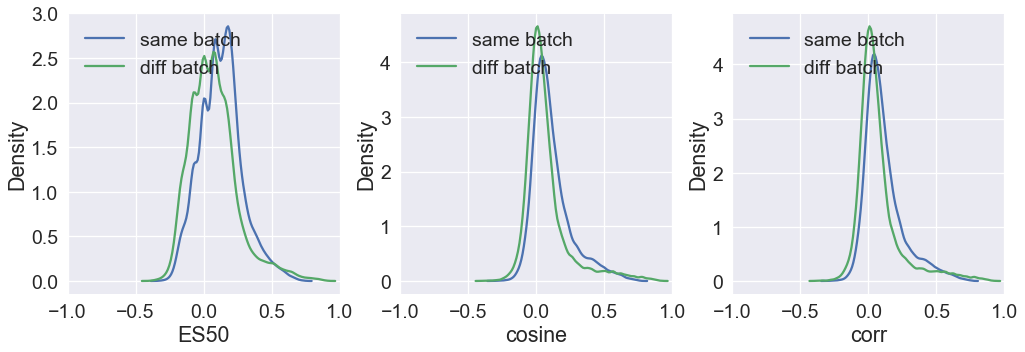

In [49]:
fig = density_plot_scores_same_drug(res_scores1)

/usr/local/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/usr/local/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


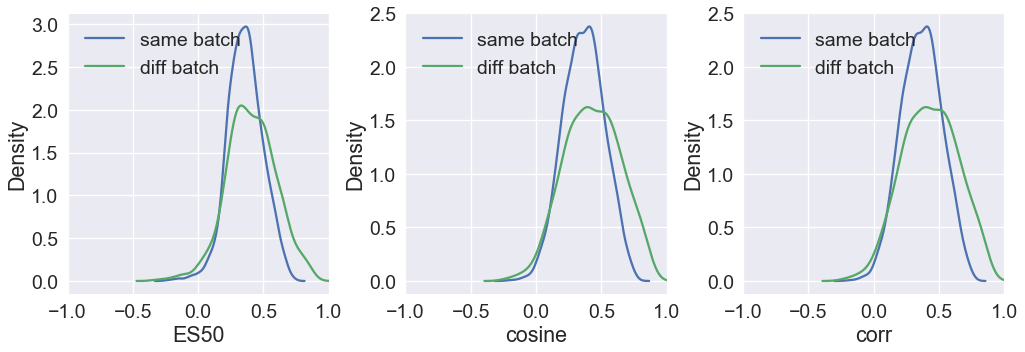

In [28]:
## without-insignificant
fig = density_plot_scores_same_drug(res_scores1)

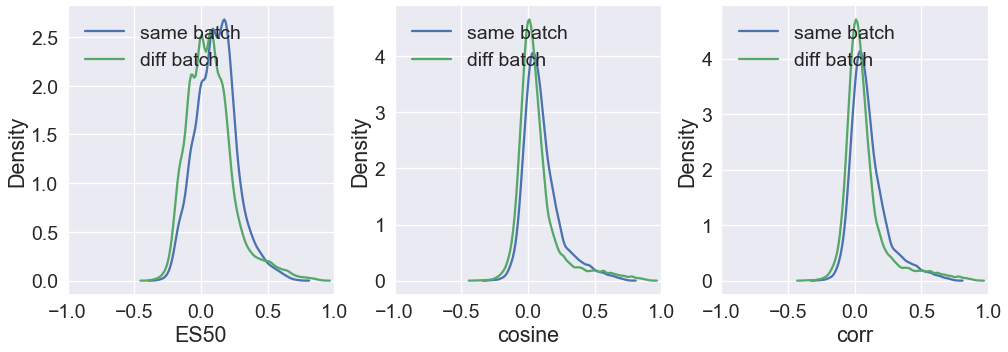

In [54]:
## core_drugs only
fig = density_plot_scores_same_drug(res_scores1)

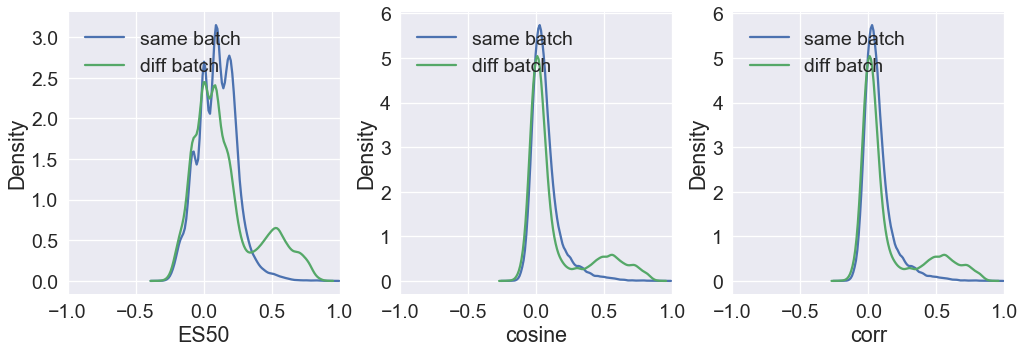

In [56]:
fig = density_plot_scores_same_drug(res_scores2)

/usr/local/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/usr/local/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


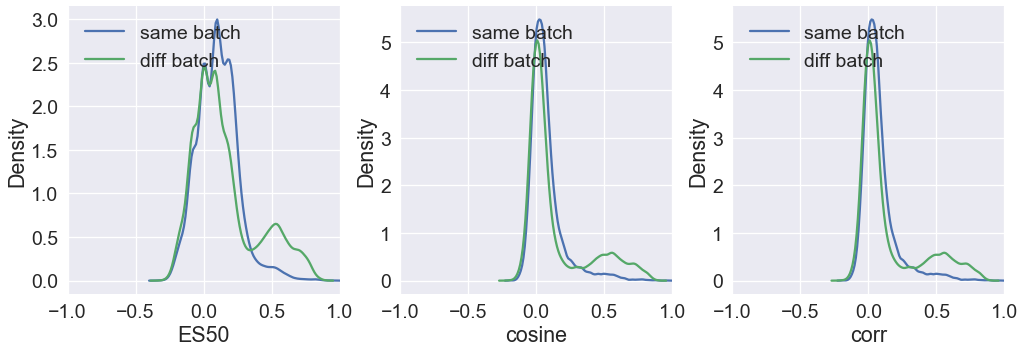

In [49]:
## core_drugs only
fig = density_plot_scores_same_drug(res_scores2)

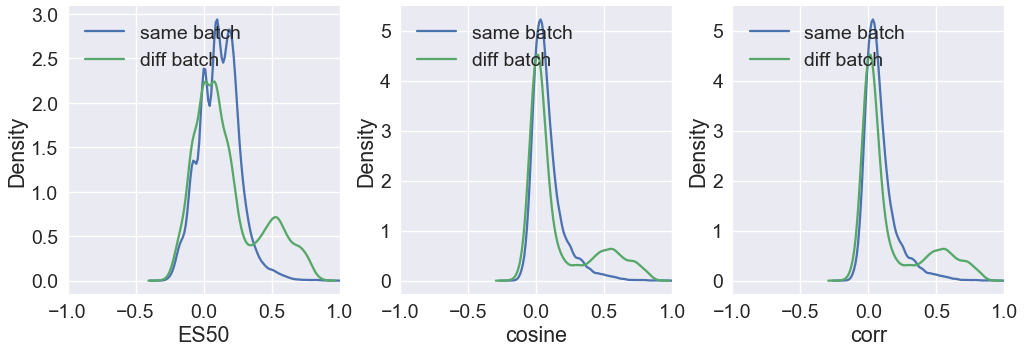

In [33]:
## without-insignificant
fig = density_plot_scores_same_drug(res_scores2)

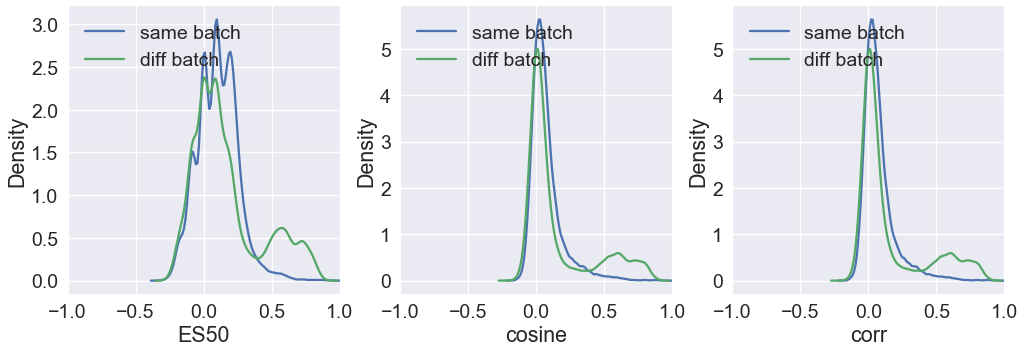

In [109]:
fig = density_plot_scores_same_drug(res_scores3)

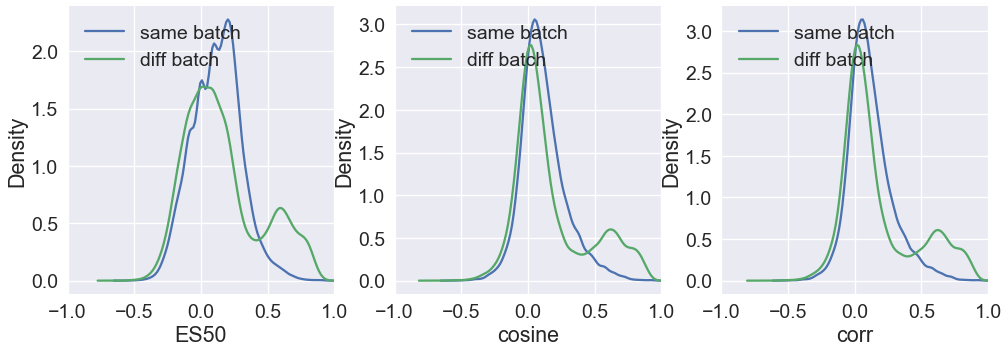

In [110]:
fig = density_plot_scores_same_drug(res_scores4)

/usr/local/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/usr/local/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


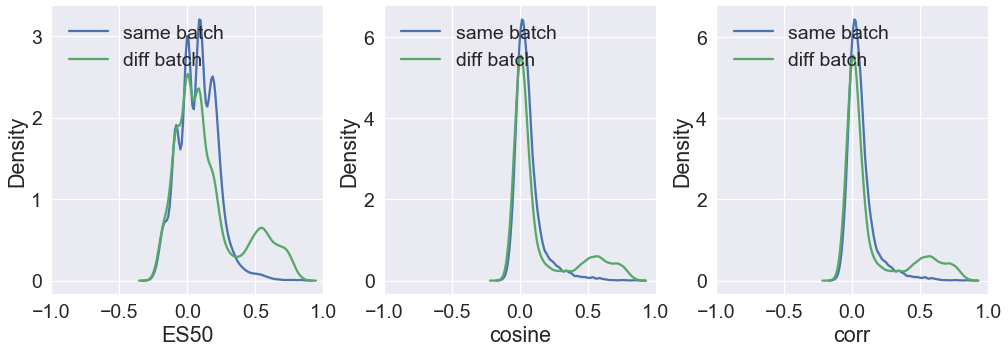

In [29]:
fig = density_plot_scores_same_drug(res_scores5)

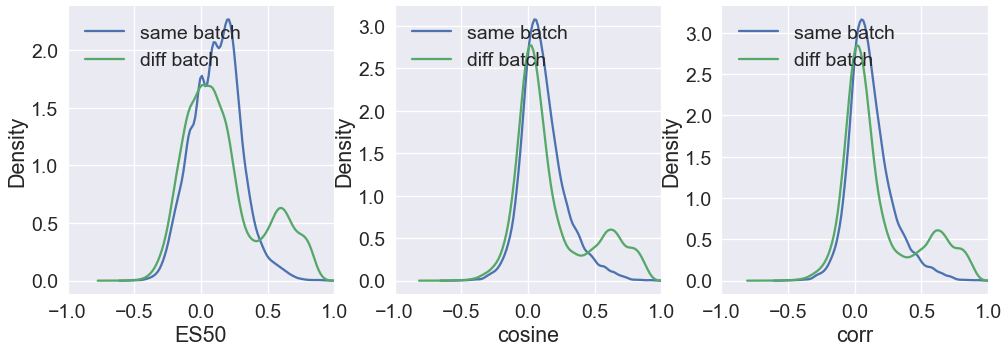

In [30]:
fig = density_plot_scores_same_drug(res_scores6)